In [193]:
# Import required libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf




In [194]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Definieer de F1-metric
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Pad naar je modelbestand
model_file_path = "unet.h5"

# Laad het model zonder optimizer
model = load_model(model_file_path, custom_objects={"f1": f1}, compile=False)
print("Model loaded successfully without optimizer!")

# Compileer het model opnieuw
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", f1])
print("Model recompiled with a new optimizer.")


Model loaded successfully without optimizer!
Model recompiled with a new optimizer.


In [195]:
# Function to preprocess the image
def preprocess_image(image_path, threshold=240):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    first_dark_column = next(
        (x for x in range(gray_image.shape[1] - 1, -1, -1) if np.all(gray_image[:, x] < threshold)), None
    )
    if first_dark_column is None:
        print("No dark columns found. Using the full image.")
        return image, gray_image
    return image[:, :first_dark_column], gray_image[:, :first_dark_column]

# Function to crop the image
def crop_image(image, gray_image, threshold=89, min_bright_pixels=5, top_crop=50):
    y_start = top_crop
    image = image[y_start:, :]
    gray_image = gray_image[y_start:, :]

    first_bright_col = next(
        (x for x in range(gray_image.shape[1]) if sum(gray_image[:, x] > threshold) >= min_bright_pixels), None
    )
    last_bright_col = next(
        (x for x in range(gray_image.shape[1] - 1, -1, -1) if sum(gray_image[:, x] > threshold) >= min_bright_pixels), None
    )
    if first_bright_col is not None and last_bright_col is not None:
        x_start = first_bright_col
        image = image[:, first_bright_col:last_bright_col + 1]
        gray_image = gray_image[:, first_bright_col:last_bright_col + 1]
    else:
        x_start = 0

    first_bright_row = next(
        (y for y in range(gray_image.shape[0]) if sum(gray_image[y, :] > threshold) >= min_bright_pixels), None
    )
    last_bright_row = next(
        (y for y in range(gray_image.shape[0] - 1, -1, -1) if sum(gray_image[y, :] > threshold) >= min_bright_pixels), None
    )
    if first_bright_row is not None and last_bright_row is not None:
        y_start += first_bright_row
        image = image[first_bright_row:last_bright_row + 1, :]
        gray_image = gray_image[first_bright_row:last_bright_row + 1]

    return image, gray_image, (y_start, x_start)


In [196]:
# Function to patch the image
def patch_image(image, patch_size=256, stride=128):
    h, w = image.shape[:2]
    patches = []
    patch_coords = []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
            patch_coords.append((y, x))
    return patches, patch_coords, h, w

# Function to reconstruct the image
def reconstruct_image(patches, patch_coords, image_shape, patch_size=256, stride=128):
    h, w = image_shape[:2]
    full_mask = np.zeros((h, w))
    overlap_count = np.zeros((h, w))
    for patch, (y, x) in zip(patches, patch_coords):
        full_mask[y:y + patch_size, x:x + patch_size] += patch
        overlap_count[y:y + patch_size, x:x + patch_size] += 1
    overlap_count[overlap_count == 0] = 1  # Avoid division by zero
    full_mask /= overlap_count
    return full_mask

# Function to normalize the mask
def normalize_mask(mask, shape):
    mask_resized = cv2.resize(mask, shape, interpolation=cv2.INTER_NEAREST)
    mask_normalized = (mask_resized > 0.5).astype(np.uint8)
    return mask_normalized


In [197]:
# Load the test image
task5_test_image_path = 'test_image_18.png'  # Replace with the image you want to test
image = cv2.imread(task5_test_image_path, 0)  # Load in grayscale
if image is not None:
    h, w = image.shape
    print(f"Height: {h}, Width: {w}")
else:
    print(f"Failed to load the image: {task5_test_image_path}")


Height: 3006, Width: 4202


In [198]:
def process_image_with_model(petri_dish_padded, model, patch_size=256, stride=128):
    patches, patch_coords, _, _ = patch_image(petri_dish_padded, patch_size=patch_size, stride=stride)

    predicted_patches = []
    for patch in patches:
        patch_rgb = np.stack((patch,) * 3, axis=-1)  # Convert to 3-channel
        patch_input = np.expand_dims(patch_rgb, axis=0)  # Add batch dimension
        prediction = model.predict(patch_input, verbose=0)
        predicted_patches.append(np.squeeze(prediction))  # Remove batch dimension

    predicted_full_mask = reconstruct_image(predicted_patches, patch_coords, petri_dish_padded.shape, patch_size=patch_size, stride=stride)

    final_mask = normalize_mask(predicted_full_mask, (petri_dish_padded.shape[1], petri_dish_padded.shape[0]))
    final_mask = (final_mask > 0.5).astype(np.uint8)  # Ensure binary mask

    # Plot the results
    fig, ax = plt.subplots(1, 2, dpi=300, figsize=(12, 6))
    ax[0].imshow(petri_dish_padded, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Original Input Image')

    ax[1].imshow(final_mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

    return final_mask


As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [199]:
# Pad the mask to the original image size
def pad_mask_to_original(mask, original_shape, cropped_coords, cropped_shape):
    """
    Pads the mask to match the original image dimensions.
    Adjusts the region of insertion dynamically based on mask size.
    """
    padded_mask = np.zeros(original_shape[:2], dtype=mask.dtype)
    y_start, x_start = cropped_coords
    
    # Determine the actual dimensions to place
    mask_h, mask_w = mask.shape
    target_h, target_w = cropped_shape
    
    # Adjust the dimensions to prevent broadcasting issues
    height = min(mask_h, target_h)
    width = min(mask_w, target_w)

    # Insert the mask into the padded area
    padded_mask[y_start:y_start + height, x_start:x_start + width] = mask[:height, :width]
    return padded_mask


Original image shape: (3006, 4111, 3)
Cropped image shape: (2776, 2763)
Cropped coordinates: (66, 753)
Padded petri dish shape: (2796, 2783)


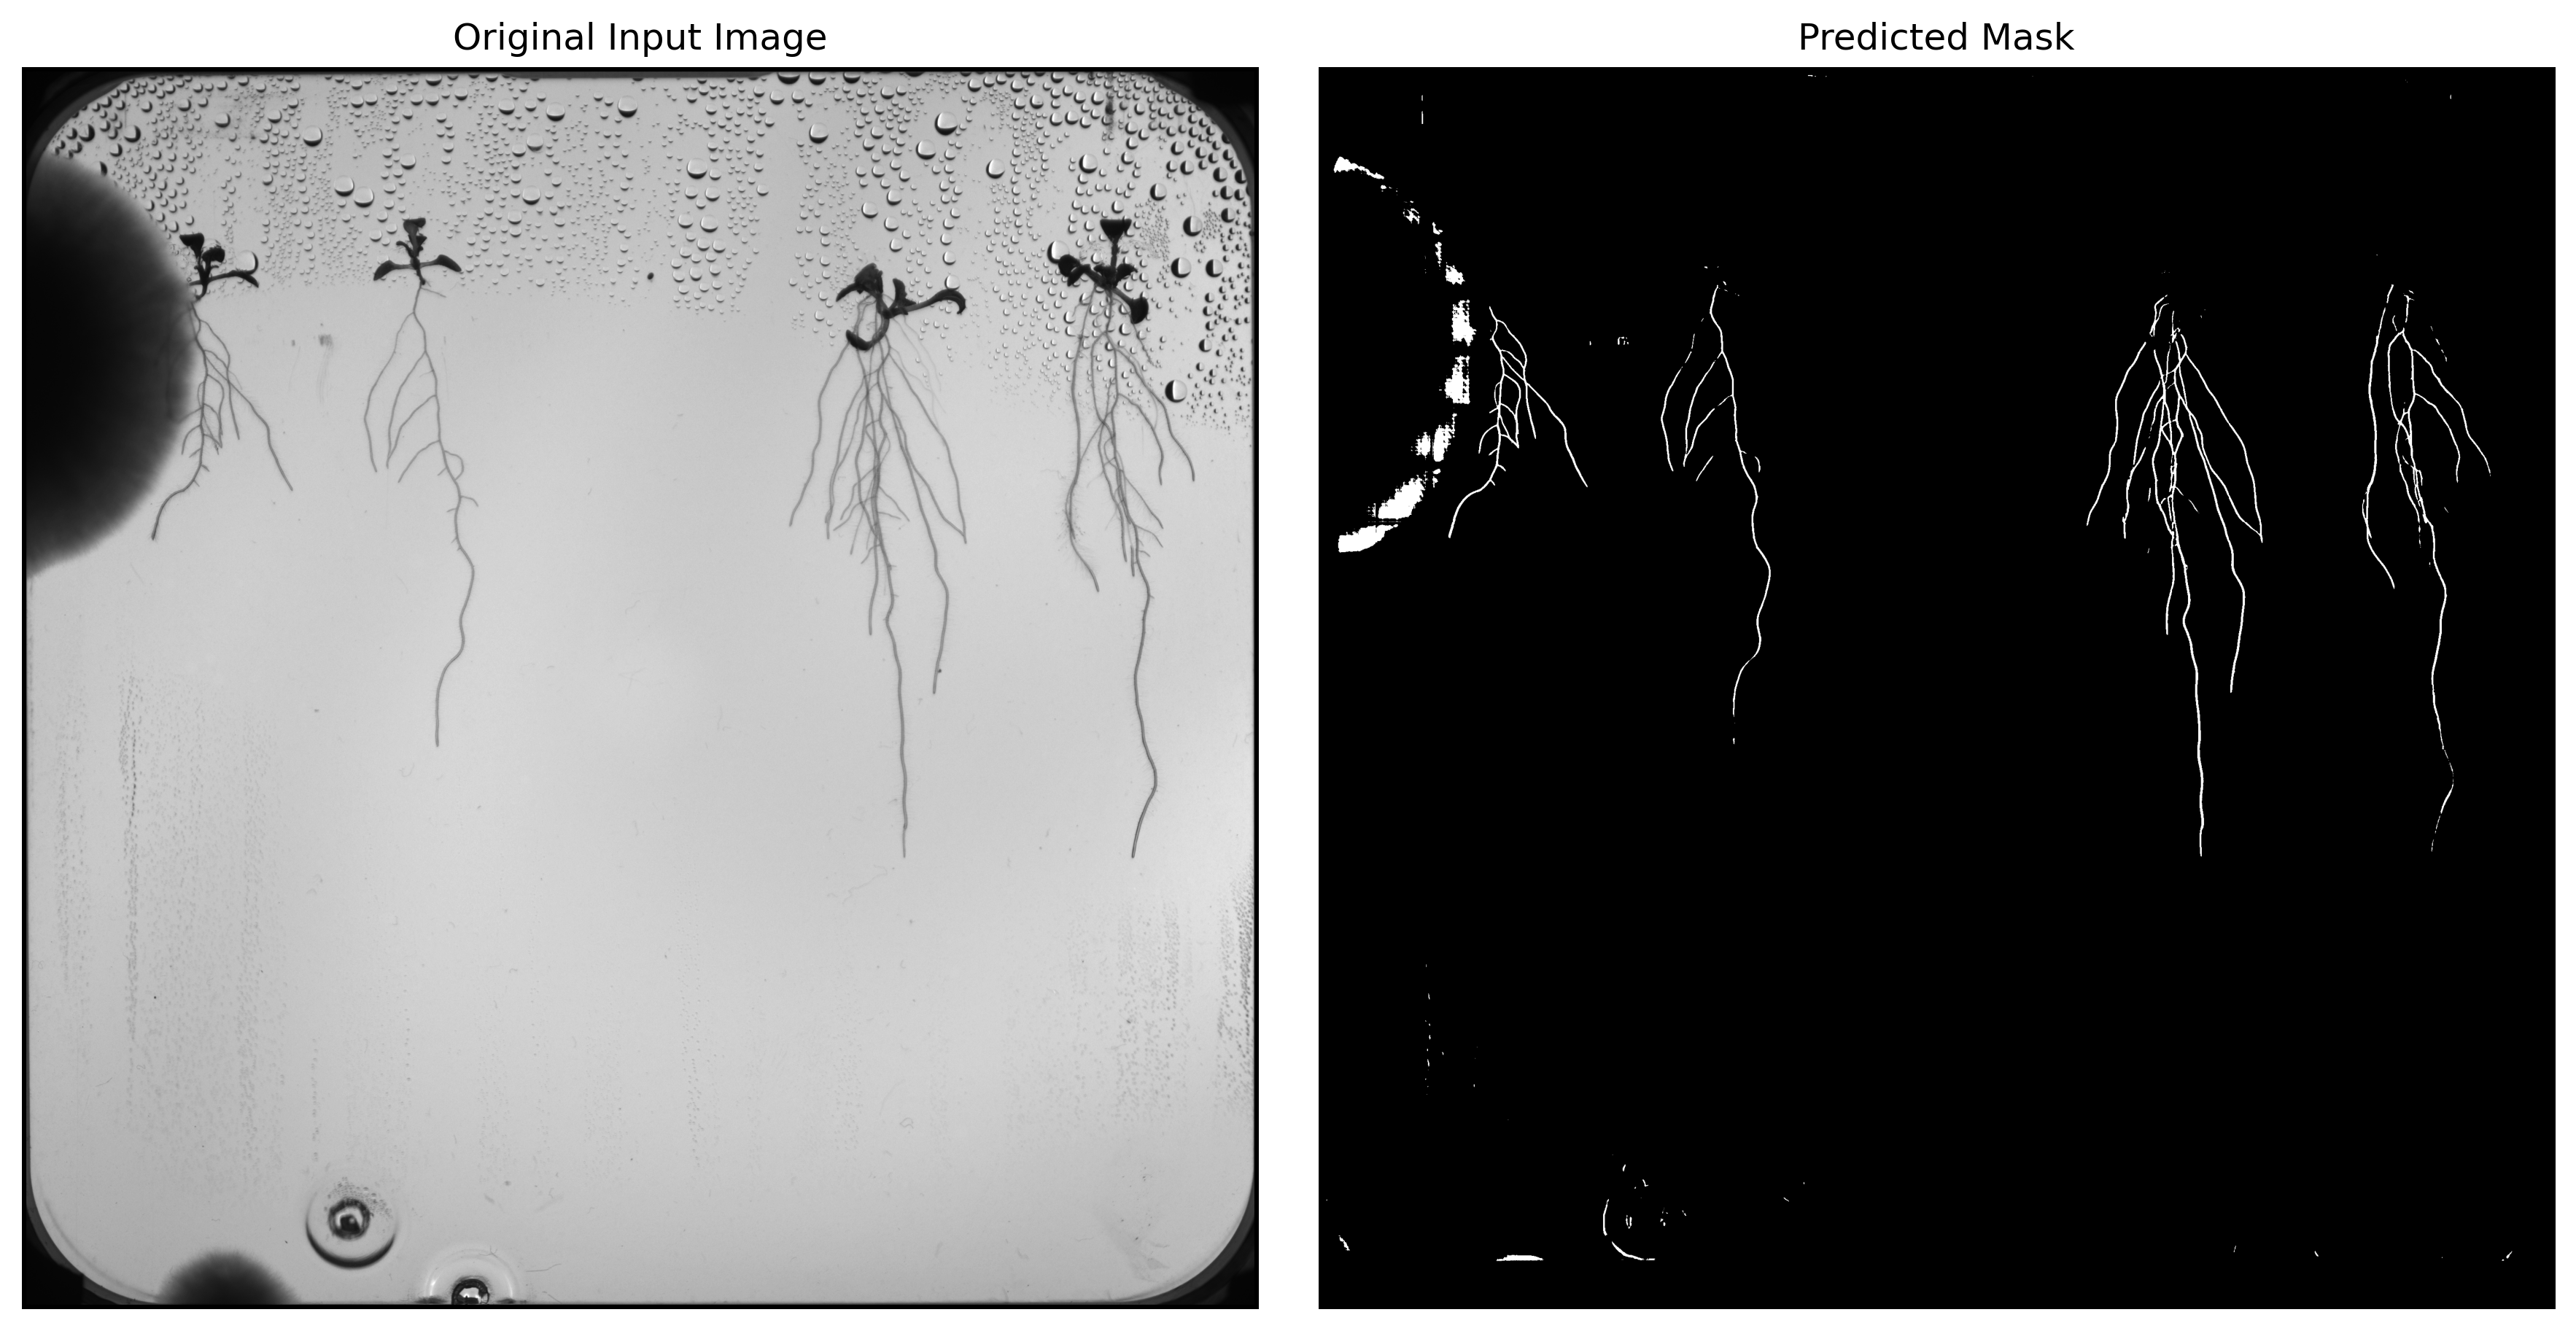

Final mask shape: (2796, 2783)


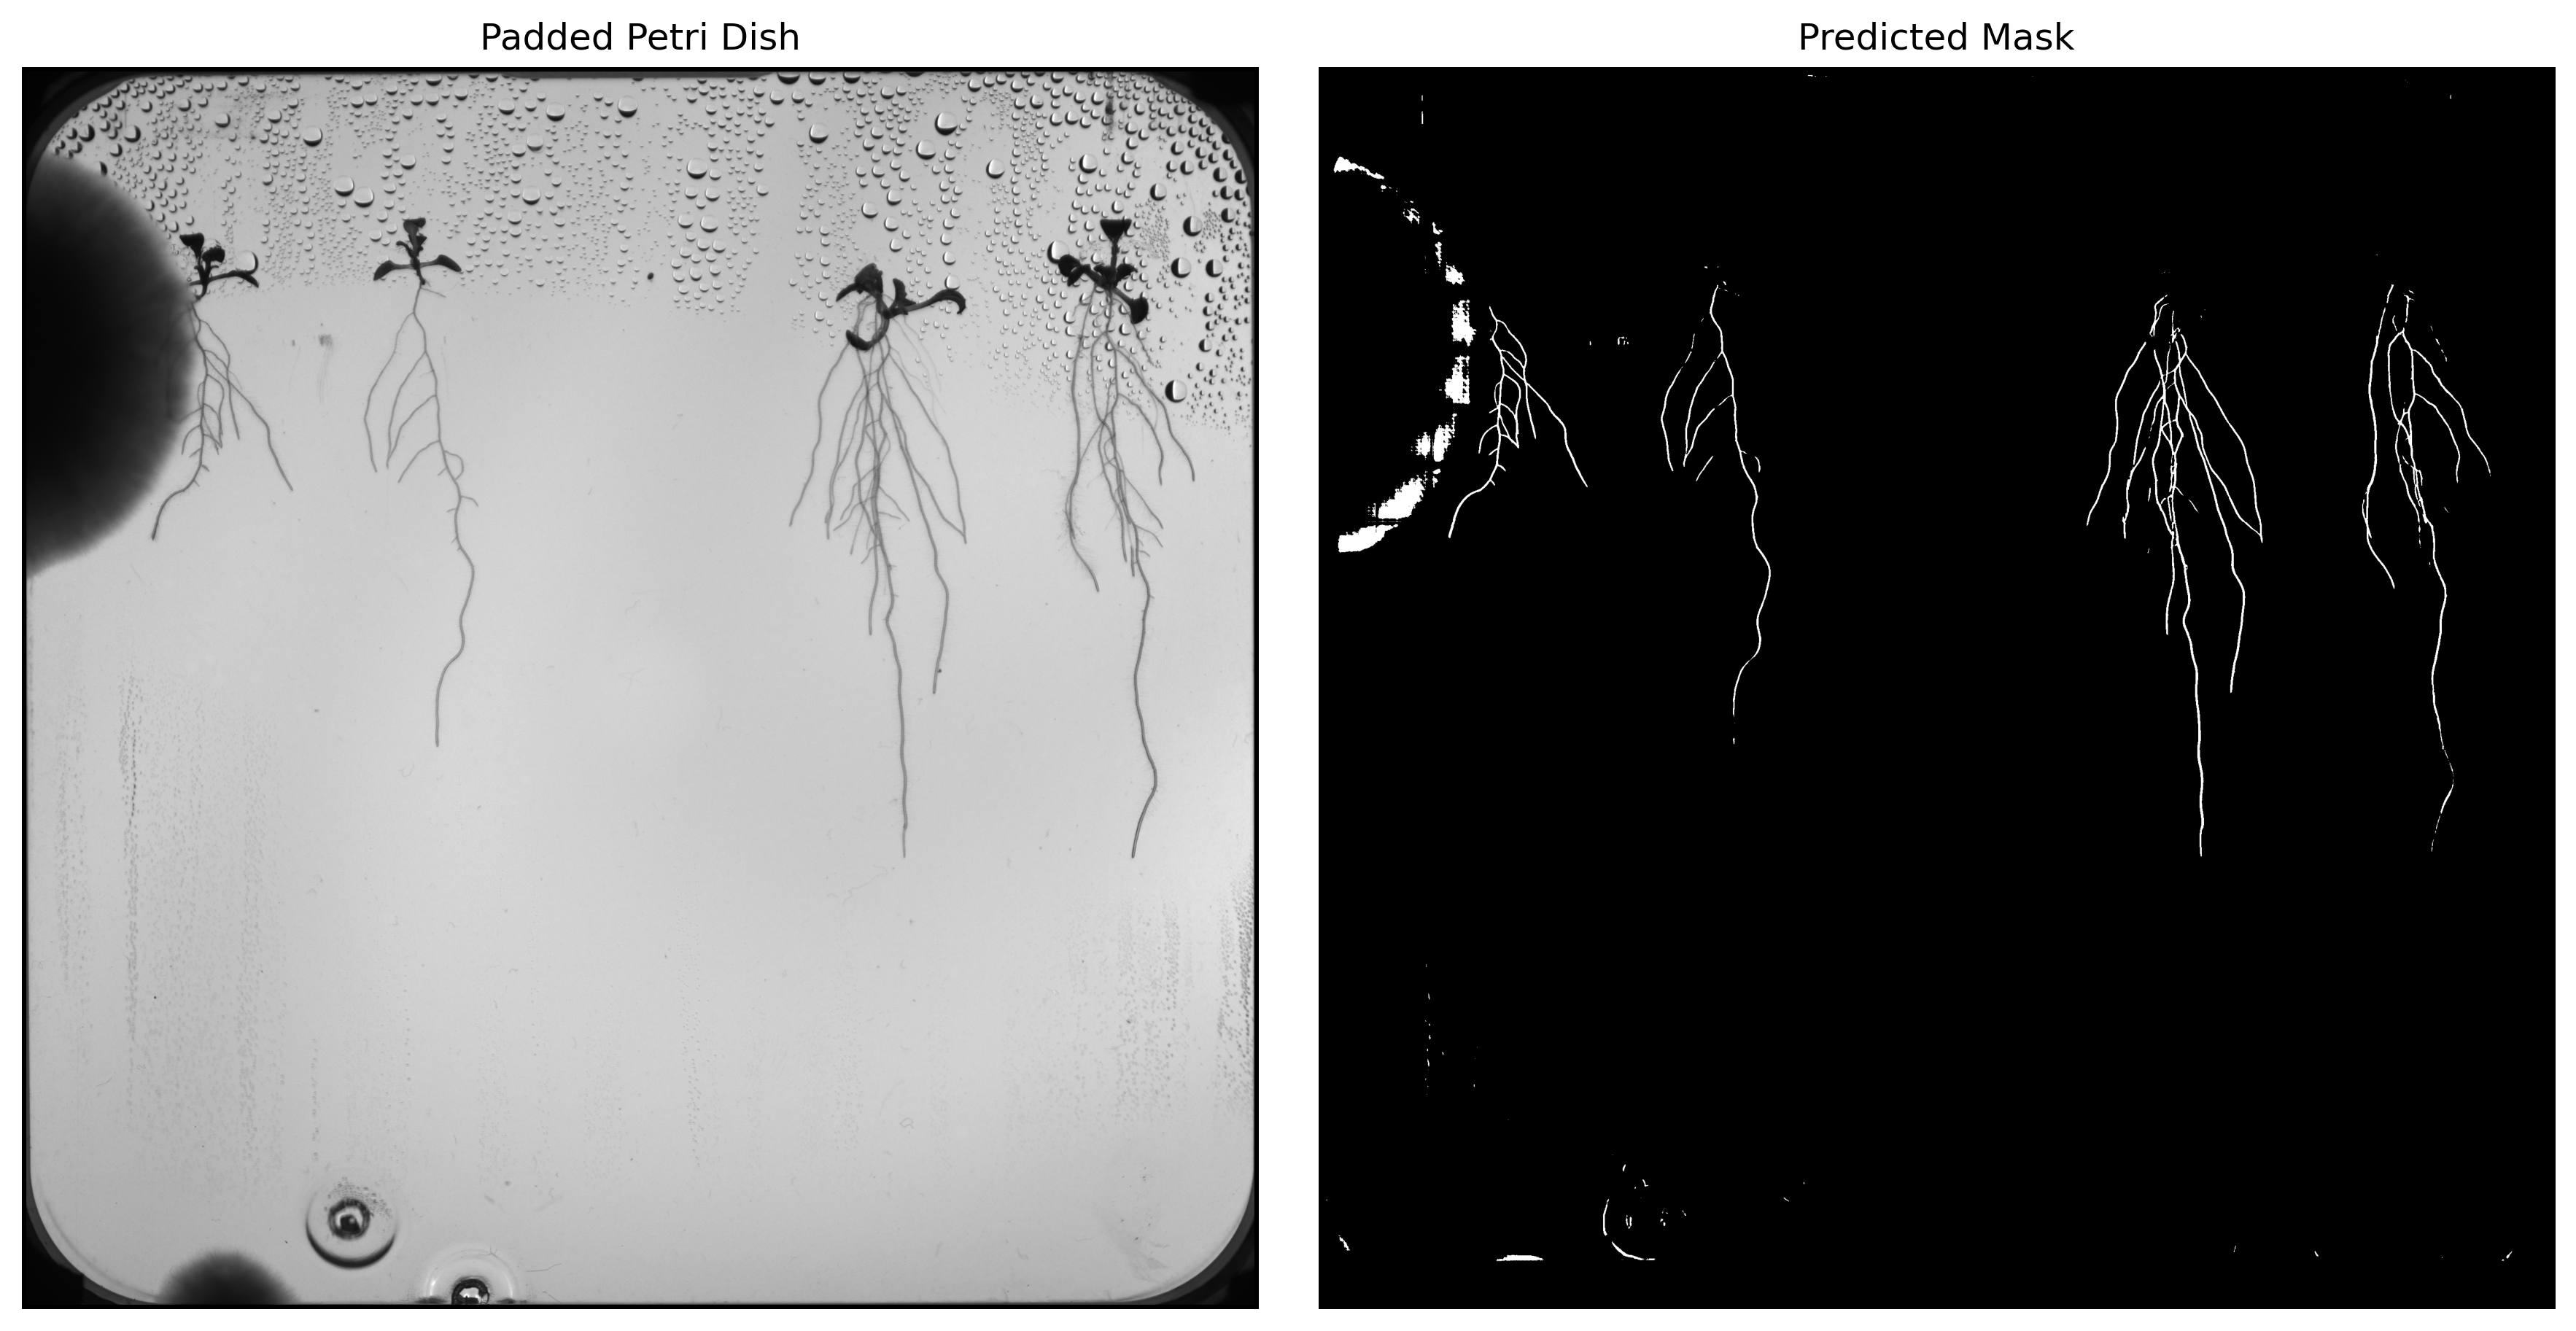

In [200]:
# Main pipeline
test_image_path = 'test_image_18.png'  # Replace with the specific image
original_image, gray_image = preprocess_image(test_image_path)
if original_image is not None:
    original_image_shape = original_image.shape
    print(f"Original image shape: {original_image_shape}")
else:
    print(f"Failed to load or preprocess the image: {test_image_path}")


# Crop the image
cropped_image, cropped_gray_image, cropped_coords = crop_image(original_image, gray_image, top_crop=50)
cropped_shape = cropped_gray_image.shape
print(f"Cropped image shape: {cropped_shape}")
print(f"Cropped coordinates: {cropped_coords}")

# Pad the petri dish
petri_dish_padded = np.pad(
    cropped_gray_image,
    ((10, 10), (10, 10)),
    mode='constant',
    constant_values=0
)
print(f"Padded petri dish shape: {petri_dish_padded.shape}")

# Normalize and predict
petri_dish_normalized = petri_dish_padded / 255.0
final_mask = process_image_with_model(petri_dish_normalized, model, patch_size=256, stride=128)
print(f"Final mask shape: {final_mask.shape}")

# Plotting only the padded petri dish and the predicted mask
fig, ax = plt.subplots(1, 2, dpi=300, figsize=(12, 6))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Padded Petri Dish')

ax[1].imshow(final_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()


In [201]:
def create_overlay_on_original(image, mask, alpha=0.5):
    """
    Create an overlay of the mask on the original image.

    Parameters:
        image (numpy array): The original image (grayscale or RGB).
        mask (numpy array): The mask to be overlayed.
        alpha (float): Transparency of the overlay. 0 is fully transparent, 1 is fully opaque.

    Returns:
        numpy array: The overlay image.
    """
    # Ensure the original image is in RGB format
    if len(image.shape) == 2:  # Grayscale image
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_rgb = image

    # Convert the mask to 3-channel RGB
    mask_rgb = np.stack((mask * 255,) * 3, axis=-1).astype(np.uint8)

    # Create the overlay
    overlay = cv2.addWeighted(image_rgb, 1 - alpha, mask_rgb, alpha, 0)
    return overlay


Padded mask shape: (3006, 4111)


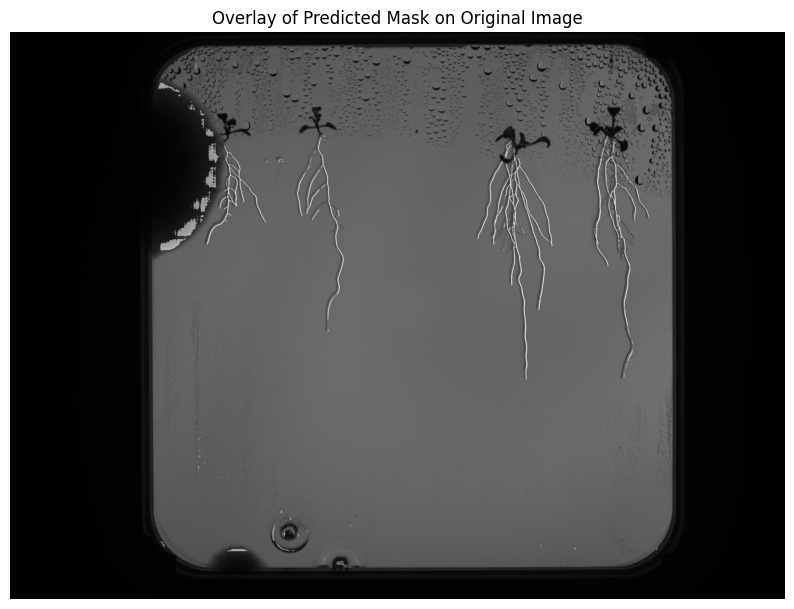

In [202]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.
# Pad the final mask to the original image size
padded_mask = pad_mask_to_original(final_mask, original_image_shape, cropped_coords, cropped_shape)
print(f"Padded mask shape: {padded_mask.shape}")

# Create the overlay
overlay_image = create_overlay_on_original(original_image, padded_mask)

# Plot the overlay
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Overlay of Predicted Mask on Original Image")
plt.axis("off")
plt.show()



In [203]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
# Ensure the padded mask matches the size of the original image
resized_padded_mask = cv2.resize(padded_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
assert resized_padded_mask.shape == original_image.shape[:2], "Mask and image shapes do not match!"
mask_image = (resized_padded_mask * 255).astype(np.uint8)
output_filename = 'task5_test_image_18_prediction_jeremy_232189.png'
cv2.imwrite(output_filename, mask_image)

print(f"Predicted mask saved as {output_filename}")


Predicted mask saved as task5_test_image_18_prediction_jeremy_232189.png


Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.

In [204]:
import os
print(f"File saved at: {os.path.abspath(output_filename)}")


File saved at: c:\Users\jerem\Desktop\Github_school\2024-25b-fai2-adsai-JeremyvanGorp232189\datalab_tasks\task5\task5_test_image_18_prediction_jeremy_232189.png
